<a href="https://colab.research.google.com/github/1985shree/Data-science-Zoomcamp-projects/blob/main/week4_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
#uploading ipynb from local folder to google drive/colab folder
from google.colab import files
uploaded = files.upload()

Saving CreditScoring.csv to CreditScoring.csv


Preparation

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
import io

df = pd.read_csv(io.BytesIO(uploaded['CreditScoring.csv']))
df.head()
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']


Your code: 
What are the categorical variables? What are the numerical?

Categorical: status,	home, marital,	records,	job,	
Numerical: seniority,	time,	age, expenses, income, 	assets, 	debt, 	amount, price

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton for that with random_state=1

In [8]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [9]:
df_train.reset_index(drop = True)
df_val.reset_index(drop = True)
df_test.reset_index(drop = True)


y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

In [10]:
del(df_train['default'])
del(df_val['default'])
del(df_test['default'])

Question 1
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the "default" variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenses'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [11]:
cat = ['home', 'marital',	'records',	'job']
num = ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']

In [12]:
df_train[num]

,seniority,time,age,expenses,income,assets,debt,amount,price
1877,12,24,28,45,102,0,0,700,1229
1803,4,60,28,60,143,0,0,1150,1630
3400,0,60,27,35,295,6000,0,1950,2208
3529,6,48,28,45,114,3500,0,650,1255
1721,12,36,42,60,0,15000,0,1000,1500
...,...,...,...,...,...,...,...,...,...
2436,0,48,54,135,0,0,0,2000,2476
1956,6,12,33,85,250,0,0,500,1500
91,9,60,32,35,105,0,0,1490,1490
3602,0,60,21,35,149,3000,0,1400,1829


In [13]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [14]:
for c in num:
  auc = roc_auc_score(y_train, df_train[c])
  if auc < 0.5:
    auc = roc_auc_score(y_train, -df_train[c])
  print(c, '   ' , auc)

seniority     0.7093778624491943
time     0.5608662489595051
age     0.5732933272499939
expenses     0.5009184217217011
income     0.682006666132633
assets     0.6486042567122802
debt     0.5047829675783548
amount     0.5910773431595518
price     0.5043329862114843


**Training the model**

From now on, use these columns only:

In [15]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']


In [16]:
from sklearn.feature_extraction import DictVectorizer

In [17]:
dv = DictVectorizer( sparse = False)

In [18]:
train_dict = df_train[features].to_dict(orient = 'records')
X_train = dv.fit_transform(train_dict)


logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [21]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [22]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

validation dataset

In [33]:
val_dict = df_val[features].to_dict(orient = 'records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

#predict_proba_ means, the probability of occurance of 0 is 0.237… and 1 is 0.762…for example...
#this comes as a list of values, for target variables being 0 and 1 here, we should have one probability for 0 and one for 1 for y_pred.
#Suppose you only want the probability of getting the output either as 0 or 1, you can do some changes in your code and you will get only one output for each observation.
# You can use the following code: model.predict_proba(test)[:,1], and we get only the probabability of selecting 1.

Question 2
What's the AUC of this model on the validation dataset? (round to 3 digits)

In [24]:
auc_val = roc_auc_score(y_val, y_pred)
auc_round = round(auc_val, 2)
print(auc_round)

0.81


**interpretation of AUC**

AUC here is the probabiliy of choosing positive prediction over negative predictions. Remember y_pred here is the array of probabilities of selecting either 0 or 1. A bootstrap will show that:

In [36]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [37]:
#random prediction of integers using numpy and bootstrapping
n= 100000
pos_idx = np.random.randint(0, len(pos), size = n)
neg_idx = np.random.randint(0, len(neg), size = n)
pos_idx

array([133, 173, 157, ..., 198,  85,  17])

In [39]:
#now checking how many predictions of bootstrap simutaions match with actual positive and negative array (pos and neg)
(pos[pos_idx] > neg[neg_idx]).mean()


0.81166

This value is close to actual 

binary model comparison

In [40]:
y_pred_binary = model.predict(X_val)#it will predict #model.predict

In [41]:
fpr, tpr, _ = roc_curve(y_val, y_pred)
fpr_b, tpr_b, _ = roc_curve(y_val, y_pred_binary)

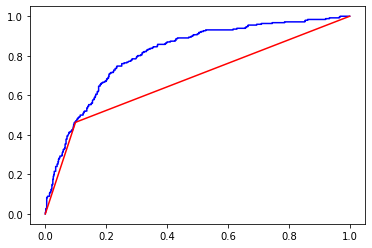

In [42]:
plt.plot(fpr, tpr, color = 'blue')
plt.plot(fpr_b, tpr_b, color = 'red')

Question 3
Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

In [43]:
#confusion matrix with iterating for thresholds using Alexey's algorithm. 

def confusion_matrix_dataframe(y_val, y_pred):
  scores = []
  thresholds= np.linspace(0, 1, 101)

  for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predicted_positive = (y_pred >=t)
    predicted_negative = (y_pred < t)

    tp = (actual_positive & predicted_positive).sum() #true positive
    tn = (actual_negative & predicted_negative).sum()# true negative
    fp = (actual_negative & predicted_positive).sum()#false positive
    fn = (actual_positive & predicted_negative).sum()# false positive

    scores.append((t, tp, tn, fp, fn))
  columns = ['threshold', 'tp', 'tn', 'fp', 'fn']  
  df_scores = pd.DataFrame(scores, columns = columns)
  return df_scores
  


In [44]:
df_scores = confusion_matrix_dataframe(y_val, y_pred)

df_scores['precision'] = df_scores['tp']/(df_scores['tp'] + df_scores['fp'])
df_scores['recall'] = df_scores['tp']/(df_scores['tp'] + df_scores['fn'])


df_scores[::10]

,threshold,tp,tn,fp,fn,precision,recall
0,0.0,246,0,645,0,0.276094,1.000000
10,0.1,235,200,445,11,0.345588,0.955285
20,0.2,215,378,267,31,0.446058,0.873984
30,0.3,187,483,162,59,0.535817,0.760163
40,0.4,140,545,100,106,0.583333,0.569106
50,0.5,114,581,64,132,0.640449,0.463415
60,0.6,78,607,38,168,0.672414,0.317073
70,0.7,37,629,16,209,0.698113,0.150407
80,0.8,21,640,5,225,0.807692,0.085366
90,0.9,6,643,2,240,0.750000,0.024390


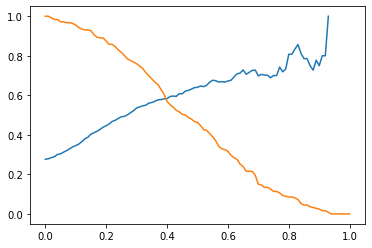

In [45]:
plt.plot(df_scores.threshold, df_scores.precision)
plt.plot(df_scores.threshold, df_scores.recall)

**Question 4**

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R) (hey this looks like the formula for reduced mass!!)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

In [46]:
df_scores['F1'] = 2 * df_scores['precision'] * df_scores['recall']/(df_scores['precision'] + df_scores['recall'])

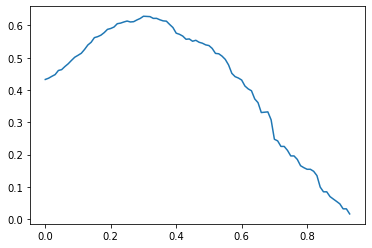

In [47]:
plt.plot(df_scores.threshold, df_scores.F1)

In [53]:
df_scores['F1'].argmax()

30

In [54]:
df_scores['threshold'].iloc[30]

0.3

**Question 5**

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

Iterate over different folds of df_full_train

Split the data into train and validation

Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

In [55]:
from sklearn.feature_extraction import DictVectorizer

In [142]:
def train(df_train, y_train, C):
  dicts = df_train[cat + num].to_dict(orient = 'records')

  dv = DictVectorizer(sparse = False)
  X_train = dv.fit_transform(dicts)
  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  model.fit(X_train, y_train)

  return dv, model


In [143]:
def predict(df, dv, model):
  dicts = df_val[cat + num].to_dict(orient = 'records')
  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred


In [144]:
from sklearn.model_selection import KFold

In [145]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

In [122]:
train_idx, val_idx = next(kfold.split(df_full_train))
#The next() function returns the next item from the iterator.
#kfold_split : splits train data, here it's the full_train data into train and val sets

In [ ]:
len(train_idx), len(val_idx)

In [147]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
  df_train = df_full_train.iloc[train_idx]
  df_val = df_full_train.iloc[val_idx]

  y_train = df_train.default.values
  dv, model = train(df_train, y_train, C= 1.0)

  y_val = df_val.default.values
  y_pred = predict(df_val, dv, model)

  auc = roc_auc_score(y_val, y_pred)
  scores.append(auc)



In [148]:
scores

[0.8552717552717553,
 0.8651451045825636,
 0.8297229972100437,
 0.8564831191290335,
 0.8171524250078043]

In [149]:
np.mean(scores)

0.84475508024024

In [150]:
np.std(scores)

0.018175646006035235

**Question 6**
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.01, 0.1, 1, 10]

Initialize KFold with the same parameters as previously

Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)

Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

0.01

0.1

1

10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

In [151]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 1)

In [152]:
model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)

In [154]:
for C in [0.01, 0.1, 1, 10]:
  scores = []
  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.default.values
    dv, model = train(df_train, y_train, C= C)

    y_val = df_val.default.values
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)
  mean = np.mean(scores)
  std_dev = np.std(scores)
  print(C, mean, std_dev)  

0.01 0.8338085258608743 0.020169906622779638
0.1 0.84240095225638 0.01823289974594603
1 0.84475508024024 0.018175646006035235
10 0.8436289690990373 0.016805468145971354
